# importing libraries

In [55]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
import pickle
import joblib

# import data handling tools
#import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
from PIL import Image

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.applications.vgg19 import preprocess_input

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install Pillow==7.2.0


In [ ]:
!pip install -U pip
!pip install git+https://github.com/cleanlab/cleanvision.git
!pip install --upgrade Pillow

In [ ]:
from cleanvision.imagelab import Imagelab

### Connecting to Google Driving

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


In [7]:
%cd '/content/drive/MyDrive/'

/content/drive/MyDrive


### Exploring the impact of Malaria in the United States

In [10]:
dataframe_dir = 'Final_Project/Data'
us_dir = os.path.join(dataframe_dir, 'US_Malaria.xlsx')
XLS = pd.ExcelFile(us_dir)
df_cases = pd.read_excel(XLS, "Data")

In [11]:
df_cases = df_cases.drop("Unnamed: 0", axis =1)
df_cases = df_cases.drop(df_cases.index[0:4])
df_cases.rename(columns = {"Unnamed: 1":"Year", "Unnamed: 2":"Malaria Cases"}, inplace = True)
df_cases.reset_index(drop=True, inplace = True)

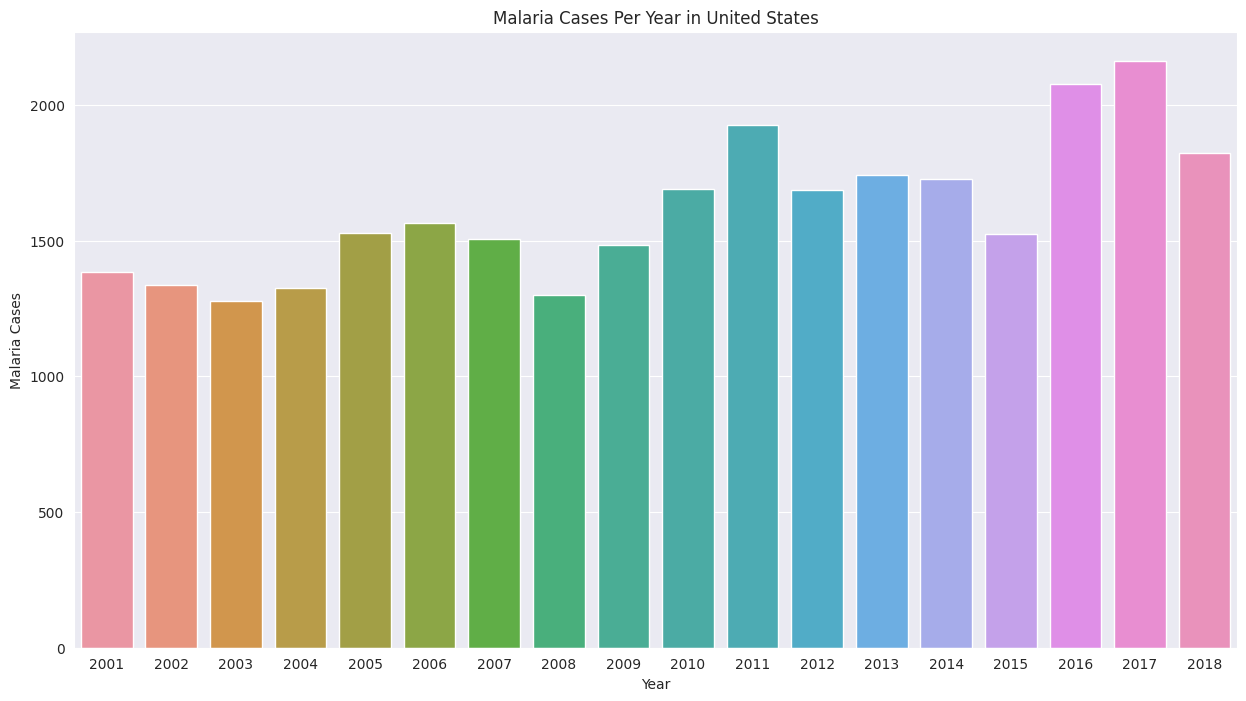

In [13]:
plt.figure(figsize=(15, 8))
sns.barplot(data=df_cases, x="Year", y = 'Malaria Cases')
plt.title("Malaria Cases Per Year in United States");

### Exploring the impact of Malaria in Worldwide

In [15]:
data = {
    'Year': [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021],
    'African': [104478030, 102278324, 113761255, 125732311, 135095910, 142473526, 160847397, 164222522, 157996344, 168282485, 168364949, 174962186],
    'Eastern Mediterranean': [6369494, 5952130, 5835463, 4946316, 5343572, 5420260, 3683265, 4464691, 5289329, 4492250, 4198608, 4805377],
    'European': [271, 252, 666, 328, 270, 238, 226, 231, 255, 295, 144, None],
    'Americas': [677583, 495221, 471841, 468931, 410975, 479057, 651224, 932341, 930469, 848994, 589418, 524158],
    'South-East Asia': [3085804, 2504444, 2144568, 1681812, 1696800, 1659425, 1477428, 1240255, 752907, 671608, 512084, 558990],
    'Western Pacific': [1792851, 1429780, 1122080, 1372377, 923262, 813712, 954305, 1069932, 1104615, 790987, 1049905, 90273]}

df = pd.DataFrame(data)





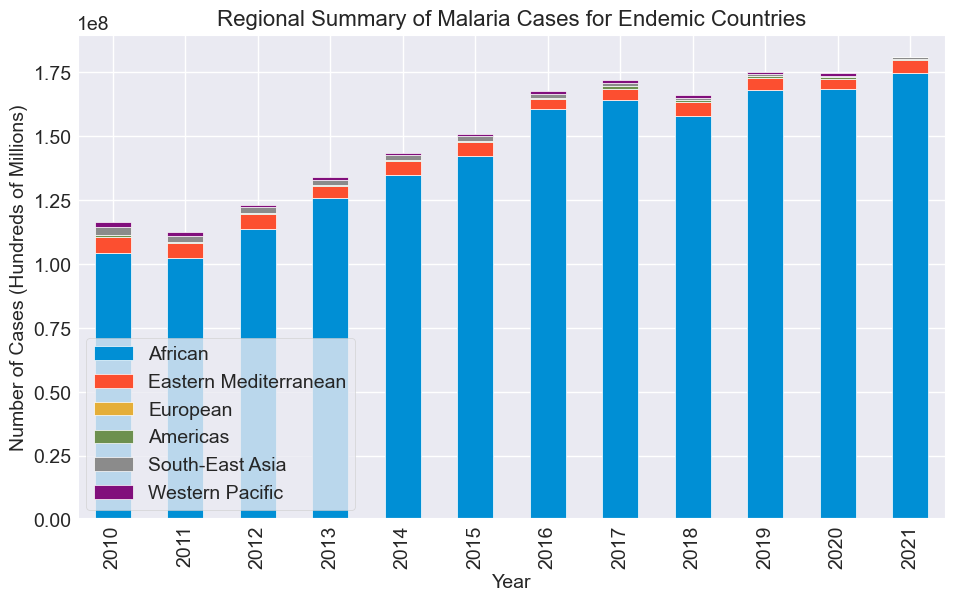

In [68]:
df = pd.DataFrame(data)

ax = df.plot(kind='bar', stacked=True, x='Year', figsize=(10, 6))
ax.set_title('Regional Summary of Malaria Cases for Endemic Countries', fontsize=16)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Number of Cases (Hundreds of Millions)', fontsize=14)
plt.show()

### Train, Test, Split Images

In [20]:
# set up paths to the image folders
parasitized_dir = 'cell_images/Parasitized'
uninfected_dir = 'cell_images/Uninfected'

# get a list of all the image filenames
parasitized_images = os.listdir(parasitized_dir)
uninfected_images = os.listdir(uninfected_dir)

# create a list of all the image paths
image_paths = []
for img in parasitized_images:
    image_paths.append(os.path.join(parasitized_dir, img))
for img in uninfected_images:
    image_paths.append(os.path.join(uninfected_dir, img))

# create an array of labels (0 for uninfected, 1 for parasitized)
labels = np.zeros(len(image_paths))
labels[:len(parasitized_images)] = 1

# split the data into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)


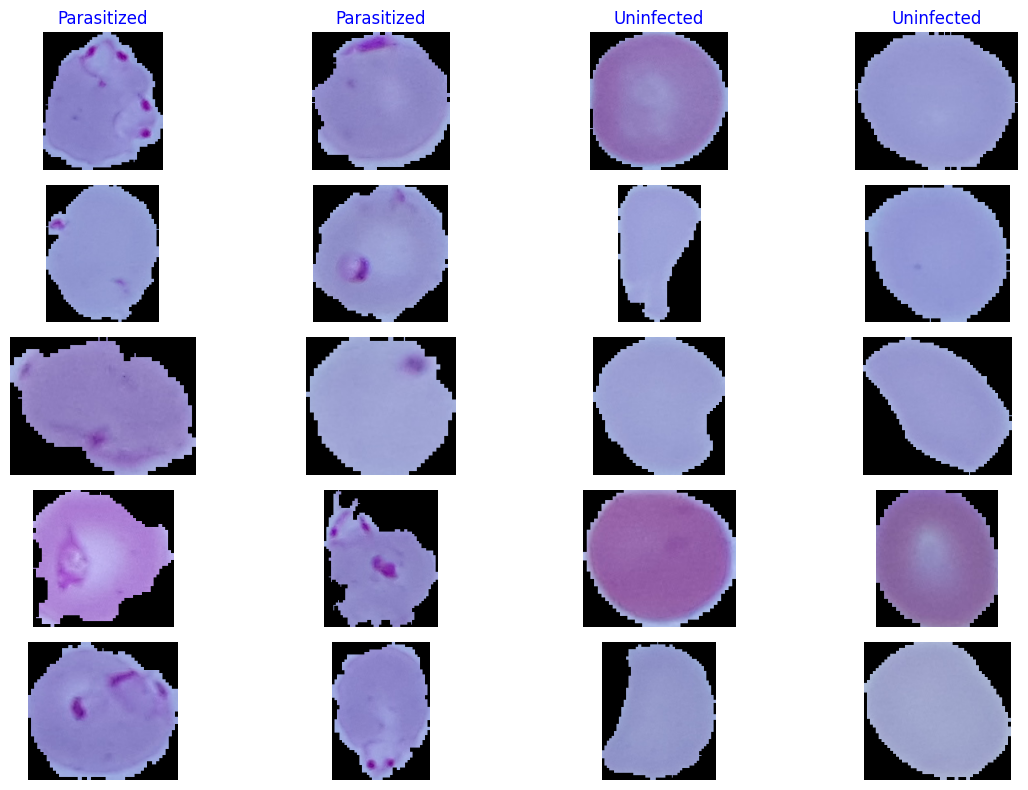

In [ ]:
# Visualizing Data

fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(12, 8))

# Display 10 parasitized images on the left and 10 Uninfected images on the right
for i in range(5):
    axs[i, 0].imshow(cv2.imread(image_paths[i]))
    axs[i, 0].axis('off')

for i in range(5, 10):
    axs[i - 5, 1].imshow(cv2.imread(image_paths[i]))
    axs[i - 5, 1].axis('off')

for i in range(5):
  axs[i, 2].imshow(cv2.imread(image_paths[-10 + i]))
  axs[i, 2].axis('off')


for i in range(5, 10):
  axs[i - 5, 3].imshow(cv2.imread(image_paths[-10 + i]))
  axs[i - 5, 3].axis('off')

# Add labels for the first and last images
axs[0, 0].set_title("Parasitized", color= 'blue', fontsize= 12, loc = "center")
axs[0, 1].set_title("Parasitized", color= 'blue', fontsize= 12, loc = "center")
axs[0, 2].set_title("Uninfected", color= 'blue', fontsize= 12, loc = "center")
axs[0, 3].set_title("Uninfected", color= 'blue', fontsize= 12, loc = "center")

plt.tight_layout()

plt.show()



In [ ]:
directories = {'Class_0': uninfected_dir,
'Class_1': parasitized_dir}

'''Returns dimenstions for an RBG image'''
def get_dims(file):
  im = Image.open(file)
  arr = np.array(im)
  h,w,d = arr.shape
  return h,w


In [ ]:
dim = get_dims(image_paths[0])
dim
list = []
list.append(dim)
list

[(160, 139)]

In [ ]:
len(image_paths)

27560

In [ ]:
dim_list = []
for i in range(len(image_paths)):
  image_paths1 = image_paths[i]
  if image_paths1 == 'Final_Project/cell_images/Parasitized/Thumbs.db':
    pass
  elif image_paths1 == 'Final_Project/cell_images/Uninfected/Thumbs.db':
    pass
  else:
    dimensions = get_dims(image_paths1)
    dim_list.append(dimensions)


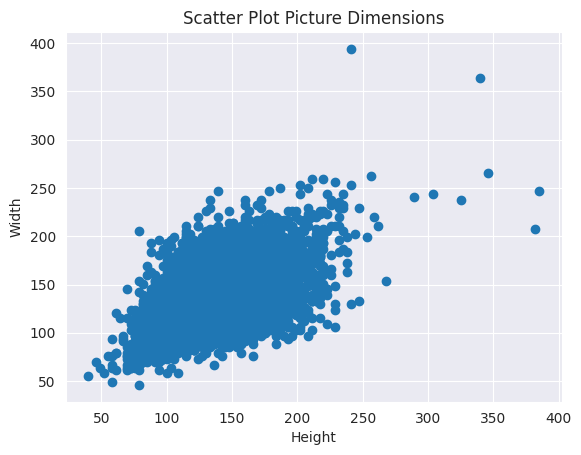

In [ ]:
#make graph looking at dimensions
x_vals = [coord[0] for coord in dim_list]
y_vals = [coord[1] for coord in dim_list]

# create the scatter plot
plt.scatter(x_vals, y_vals)

# set the plot title and axis labels
plt.title('Scatter Plot Picture Dimensions')
plt.xlabel('Height')
plt.ylabel('Width')

# display the plot
plt.show()

The graph above shows that the image files that are in my two image directories are all different sizes. I will make them all 128 by 128 pixels

In [21]:
train_labels = [str(i) for i in train_labels]
test_labels = [str(i) for i in test_labels]

In [22]:
# create a dataframe with the image file paths and corresponding labels
df_train = pd.DataFrame({
    'file_path': train_images,  # a list of image file paths
    'label': train_labels  # a list of corresponding image labels
})

# set the image size you want to use for training
image_size = (128, 128)

# create an instance of the ImageDataGenerator for data preprocessing
data_gen = ImageDataGenerator(rescale=1./255)

# use the flow_from_dataframe method to load and preprocess the images
data_generator_train = data_gen.flow_from_dataframe(
    dataframe=df_train,
    x_col='file_path',
    y_col='label',
    target_size=image_size,
    batch_size=32,
    class_mode='binary'
)

Found 22047 validated image filenames belonging to 2 classes.


In [56]:
# create a dataframe with the image file paths and corresponding labels
df_train = pd.DataFrame({
    'file_path': train_images,  # a list of image file paths
    'label': train_labels  # a list of corresponding image labels
})

# set the image size you want to use for training
image_size = (128, 128)

# create an instance of the ImageDataGenerator for data preprocessing
data_gen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)

# use the flow_from_dataframe method to load and preprocess the images
data_generator_train_VGG19 = data_gen.flow_from_dataframe(
    dataframe=df_train,
    x_col='file_path',
    y_col='label',
    target_size=image_size,
    batch_size=32,
    class_mode='binary'
)

Found 22047 validated image filenames belonging to 2 classes.


In [ ]:
# generate all the images and labels in numpy array format
num_samples = len(data_generator_train.filenames)
images_array = []
labels_array = []

for i in range(num_samples // 32):
    batch_images, batch_labels = data_generator_train.next()
    start_idx = i * 32
    end_idx = start_idx + batch_images.shape[0]
    images_array[start_idx:end_idx] = batch_images
    labels_array[start_idx:end_idx] = batch_labels

# process any remaining images if batch_size doesn't evenly divide into num_samples
if num_samples % 32 > 0:
    batch_images, batch_labels = data_generator_train.next()
    start_idx = (num_samples // 32) * 32
    end_idx = start_idx + batch_images.shape[0]
    images_array[start_idx:end_idx] = batch_images
    labels_array[start_idx:end_idx] = batch_labels

In [ ]:
image_frame = pd.DataFrame({
    'image': images_array,
    'label': labels_array})

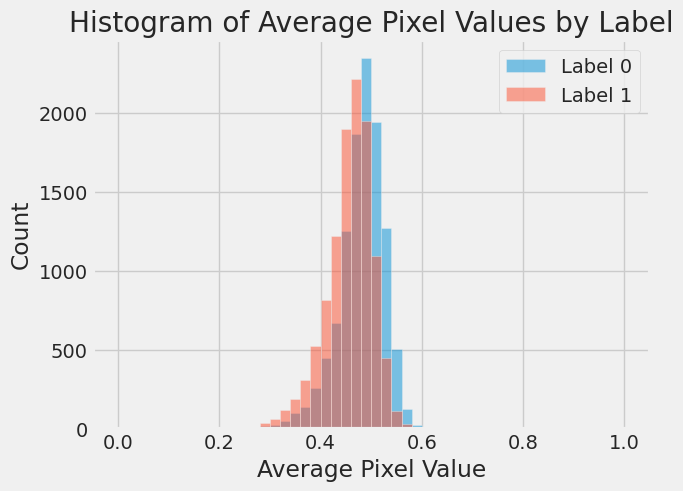

In [ ]:
#image pixel density

# Calculate the average pixel value for each group separately
average_pixel_values_0 = [np.mean(image) for image in image_frame[image_frame['label'] == 0]['image']]
average_pixel_values_1 = [np.mean(image) for image in image_frame[image_frame['label'] == 1]['image']]

# Plot a histogram of the average pixel values for each group
plt.hist(average_pixel_values_0, bins=50, range=(0, 1), alpha=0.5, label='Label 0')
plt.hist(average_pixel_values_1, bins=50, range=(0, 1), alpha=0.5, label='Label 1')

# Set the title and axis labels
plt.title("Histogram of Average Pixel Values by Label")
plt.xlabel("Average Pixel Value")
plt.ylabel("Count")

# Add a legend
plt.legend()

# Show the plot
plt.show()



In [ ]:
# Check Class Balance
train_labels, train_counts = np.unique(data_generator_train.classes, return_counts = True)
train_counts

array([11030, 11017])

In [23]:
# create a dataframe with the image file paths and corresponding labels
df_test = pd.DataFrame({
    'file_path': test_images,  # a list of image file paths
    'label': test_labels  # a list of corresponding image labels
})

# set the image size you want to use for training
image_size = (128, 128)

# create an instance of the ImageDataGenerator for data preprocessing
data_gen = ImageDataGenerator(rescale=1./255)

# use the flow_from_dataframe method to load and preprocess the images
data_generator_test = data_gen.flow_from_dataframe(
    dataframe=df_test,
    x_col='file_path',
    y_col='label',
    target_size=image_size,
    batch_size=32,
    class_mode='binary',
    shuffle = False
)

Found 5511 validated image filenames belonging to 2 classes.


In [57]:
# create a dataframe with the image file paths and corresponding labels
df_test = pd.DataFrame({
    'file_path': test_images,  # a list of image file paths
    'label': test_labels  # a list of corresponding image labels
})

# set the image size you want to use for training
image_size = (128, 128)

# create an instance of the ImageDataGenerator for data preprocessing
data_gen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)

# use the flow_from_dataframe method to load and preprocess the images
data_generator_test_VGG19 = data_gen.flow_from_dataframe(
    dataframe=df_test,
    x_col='file_path',
    y_col='label',
    target_size=image_size,
    batch_size=32,
    class_mode='binary',
    shuffle = False
)

Found 5511 validated image filenames belonging to 2 classes.


In [ ]:
# generate all the images and labels in numpy array format
num_samples = len(data_generator_test.filenames)
images_array_test = []
labels_array_test = []

for i in range(num_samples // 32):
    batch_images, batch_labels = data_generator_test.next()
    start_idx = i * 32
    end_idx = start_idx + batch_images.shape[0]
    images_array[start_idx:end_idx] = batch_images
    labels_array[start_idx:end_idx] = batch_labels

# process any remaining images if batch_size doesn't evenly divide into num_samples
if num_samples % 32 > 0:
    batch_images, batch_labels = data_generator_test.next()
    start_idx = (num_samples // 32) * 32
    end_idx = start_idx + batch_images.shape[0]
    images_array[start_idx:end_idx] = batch_images
    labels_array[start_idx:end_idx] = batch_labels

In [ ]:
test_labels, test_counts = np.unique(data_generator_test.classes, return_counts = True)
test_counts

array([2749, 2762])

# EDA


In [ ]:
# Clean Photos
imagelab_para = Imagelab(data_path=parasitized_dir)
imagelab_para.find_issues()


Reading images from /content/drive/MyDrive/Final_Project/cell_images/Parasitized
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale images ...


100%|██████████| 13779/13779 [00:48<00:00, 285.78it/s]


Issue checks completed. To see a detailed report of issues found, use imagelab.report().


In [ ]:
imagelab_para.report()

No issues found.


In [ ]:
imagelab_unin = Imagelab(data_path=uninfected_dir)
imagelab_unin.find_issues()

Reading images from /content/drive/MyDrive/Final_Project/cell_images/Uninfected
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale images ...


100%|██████████| 13779/13779 [00:56<00:00, 242.96it/s]


Issue checks completed. To see a detailed report of issues found, use imagelab.report().


Issues found in order of severity in the dataset

|    | issue_type      |   num_images |
|---:|:----------------|-------------:|
|  0 | near_duplicates |            2 | 

Found 1 set of images with near_duplicates issue in the dataset.
Set: 0


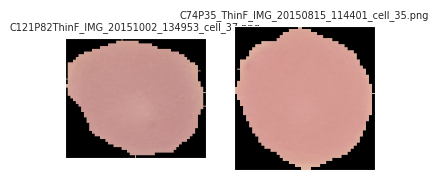

In [ ]:
imagelab_unin.report()

The imagelab reports show that there are no blurry, blank or corrupted images in either directory. Now that I know that the images are of a good quality, I will...

# Creating CNN

### Model 1

In [ ]:
#instantiate a model
base_model = Sequential()


# add the input layer  
base_model.add(Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(128, 128, 3)))


# max pool in 2x2 window
base_model.add(MaxPooling2D(pool_size=(2, 2)))

# connect all nodes with dense layers
base_model.add(Flatten())
base_model.add(Dense(32, activation='relu'))
base_model.add(Dense(1, activation='sigmoid'))

#using adam optimizer, binary_crossentropy to measure loss and accuracy as our metric  
base_model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])


In [ ]:
history_base = base_model.fit(data_generator_train, steps_per_epoch = 20, epochs = 10)

Epoch 1/10
20/20 [==============================] - 11s 432ms/step - loss: 1.7273 - accuracy: 0.5078
Epoch 2/10
20/20 [==============================] - 11s 547ms/step - loss: 0.6933 - accuracy: 0.4812
Epoch 3/10
20/20 [==============================] - 11s 544ms/step - loss: 0.6930 - accuracy: 0.5219
Epoch 4/10
20/20 [==============================] - 10s 492ms/step - loss: 0.6931 - accuracy: 0.5109
Epoch 5/10
20/20 [==============================] - 11s 539ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 6/10
20/20 [==============================] - 9s 433ms/step - loss: 0.6932 - accuracy: 0.5016
Epoch 7/10
20/20 [==============================] - 11s 531ms/step - loss: 0.6931 - accuracy: 0.5063
Epoch 8/10
20/20 [==============================] - 9s 435ms/step - loss: 0.6931 - accuracy: 0.5109
Epoch 9/10
20/20 [==============================] - 9s 451ms/step - loss: 0.6931 - accuracy: 0.5031
Epoch 10/10
20/20 [==============================] - 11s 539ms/step - loss: 0.6932 - accuracy:

### Model 2: Adding additional Layers

In [ ]:
#instantiate a model
model_2 = Sequential()


# add the input layer  
model_2.add(Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(128, 128, 3)))
# max pool in 2x2 window
model_2.add(MaxPooling2D(pool_size=(2, 2)))


# add second convulutional layer 
model_2.add(Conv2D(filters=64,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(128, 128, 3)))

# add second max pool in 2x2 window
model_2.add(MaxPooling2D(pool_size=(2, 2)))


# add third convulutional layer 
model_2.add(Conv2D(filters=128,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(128, 128, 3)))

# add third max pool in 2x2 window
model_2.add(MaxPooling2D(pool_size=(2, 2)))


# add fourth convulutional layer 
model_2.add(Conv2D(filters=256,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(128, 128, 3)))

# add fourth max pool in 2x2 window
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# add fifth convulutional layer 
model_2.add(Conv2D(filters=512,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(128, 128, 3)))

# add fifth max pool in 2x2 window
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# connect all nodes with dense layers
model_2.add(Flatten())
model_2.add(Dense(32, activation='relu'))
model_2.add(Dense(32, activation='relu'))
model_2.add(Dense(1, activation='sigmoid'))

#using adam optimizer, binary_crossentropy to measure loss and accuracy as our metric  
model_2.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])

In [ ]:
history_model_2 = model_2.fit(data_generator_train, steps_per_epoch = 20, epochs = 10)

Epoch 1/10
20/20 [==============================] - 62s 3s/step - loss: 0.6994 - accuracy: 0.5109
Epoch 2/10
20/20 [==============================] - 56s 3s/step - loss: 0.6925 - accuracy: 0.5203
Epoch 3/10
20/20 [==============================] - 53s 3s/step - loss: 0.6672 - accuracy: 0.6266
Epoch 4/10
20/20 [==============================] - 57s 3s/step - loss: 0.5668 - accuracy: 0.7266
Epoch 5/10
20/20 [==============================] - 53s 3s/step - loss: 0.4505 - accuracy: 0.8562
Epoch 6/10
20/20 [==============================] - 48s 2s/step - loss: 0.4418 - accuracy: 0.8797
Epoch 7/10
20/20 [==============================] - 57s 3s/step - loss: 0.4874 - accuracy: 0.7625
Epoch 8/10
20/20 [==============================] - 50s 2s/step - loss: 0.2869 - accuracy: 0.9047
Epoch 9/10
20/20 [==============================] - 52s 2s/step - loss: 0.2171 - accuracy: 0.9281
Epoch 10/10
20/20 [==============================] - 43s 2s/step - loss: 0.2120 - accuracy: 0.9406


### Model 2.5: Increasings epochs and callback use

In [26]:
early_stopping = EarlyStopping(monitor='loss', patience=5)
callbacks = early_stopping

In [ ]:
#instantiate a model
model_2_5 = Sequential()


# add the input layer  
model_2_5.add(Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(128, 128, 3)))
# max pool in 2x2 window
model_2_5.add(MaxPooling2D(pool_size=(2, 2)))


# add second convulutional layer 
model_2_5.add(Conv2D(filters=64,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(128, 128, 3)))

# add second max pool in 2x2 window
model_2_5.add(MaxPooling2D(pool_size=(2, 2)))


# add third convulutional layer 
model_2_5.add(Conv2D(filters=128,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(128, 128, 3)))

# add third max pool in 2x2 window
model_2_5.add(MaxPooling2D(pool_size=(2, 2)))


# add fourth convulutional layer 
model_2_5.add(Conv2D(filters=256,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(128, 128, 3)))

# add fourth max pool in 2x2 window
model_2_5.add(MaxPooling2D(pool_size=(2, 2)))

# add fifth convulutional layer 
model_2_5.add(Conv2D(filters=512,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(128, 128, 3)))

# add fifth max pool in 2x2 window
model_2_5.add(MaxPooling2D(pool_size=(2, 2)))

# connect all nodes with dense layers
model_2_5.add(Flatten())
model_2_5.add(Dense(32, activation='relu'))
model_2_5.add(Dense(32, activation='relu'))
model_2_5.add(Dense(1, activation='sigmoid'))

#using adam optimizer, binary_crossentropy to measure loss and accuracy as our metric  
model_2_5.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])

In [ ]:
history_model_2_5 = model_2_5.fit(data_generator_train, steps_per_epoch = 20, callbacks = callbacks, epochs = 40)

Epoch 1/40
20/20 [==============================] - 35s 2s/step - loss: 0.6941 - accuracy: 0.5281
Epoch 2/40
20/20 [==============================] - 32s 2s/step - loss: 0.6932 - accuracy: 0.5125
Epoch 3/40
20/20 [==============================] - 32s 2s/step - loss: 0.6939 - accuracy: 0.4969
Epoch 4/40
20/20 [==============================] - 32s 2s/step - loss: 0.6928 - accuracy: 0.5406
Epoch 5/40
20/20 [==============================] - 32s 2s/step - loss: 0.6939 - accuracy: 0.5203
Epoch 6/40
20/20 [==============================] - 33s 2s/step - loss: 0.6931 - accuracy: 0.4969
Epoch 7/40
20/20 [==============================] - 32s 2s/step - loss: 0.6910 - accuracy: 0.5344
Epoch 8/40
20/20 [==============================] - 32s 2s/step - loss: 0.6735 - accuracy: 0.5766
Epoch 9/40
20/20 [==============================] - 32s 2s/step - loss: 0.6775 - accuracy: 0.5484
Epoch 10/40
20/20 [==============================] - 32s 2s/step - loss: 0.6050 - accuracy: 0.6625
Epoch 11/40
20/20 [

In [ ]:
# returns test accuracy and test loss
test_loss, test_accuracy = model_2_5.evaluate(data_generator_test, verbose=2)
print(test_loss, test_accuracy)

173/173 - 80s - loss: 0.1873 - accuracy: 0.9401 - 80s/epoch - 461ms/step
0.18725353479385376 0.940119743347168


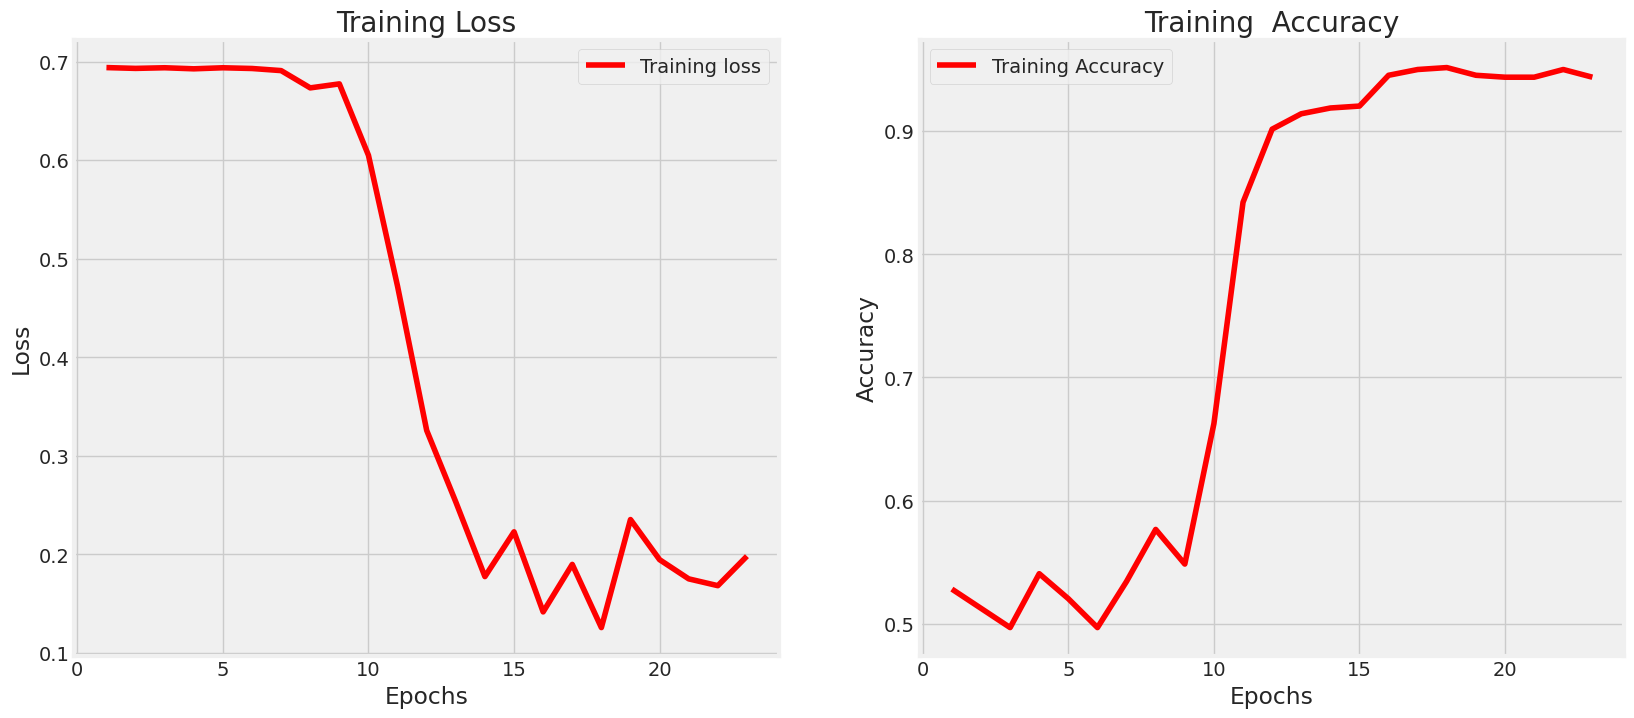

In [ ]:
# Define needed variables
tr_acc = history_model_2_5.history['accuracy']
tr_loss = history_model_2_5.history['loss']
Epochs = [i+1 for i in range(len(tr_acc))]


# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.title('Training  Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()


In [ ]:
y_proba = model_2_5.predict(data_generator_test) 

173/173 [==============================] - 82s 472ms/step


In [ ]:
y_pred = (y_proba > 0.5).astype('int')

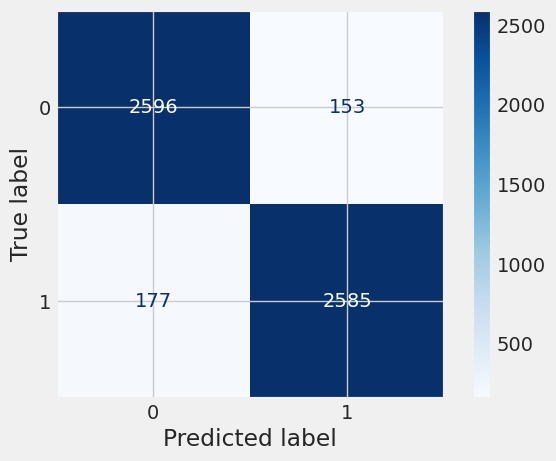

In [ ]:
y_test = data_generator_test.classes

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)

disp.plot(cmap=plt.cm.Blues)
plt.show()

### Model 2.75: Changing Callback Parameters

In [ ]:
early_stopping = EarlyStopping(monitor='accuracy', patience=5)
callbacks2 = early_stopping

In [ ]:
#instantiate a model
model_2_75 = Sequential()


# add the input layer  
model_2_75.add(Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(128, 128, 3)))
# max pool in 2x2 window
model_2_75.add(MaxPooling2D(pool_size=(2, 2)))


# add second convulutional layer 
model_2_75.add(Conv2D(filters=64,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(128, 128, 3)))

# add second max pool in 2x2 window
model_2_75.add(MaxPooling2D(pool_size=(2, 2)))


# add third convulutional layer 
model_2_75.add(Conv2D(filters=128,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(128, 128, 3)))

# add third max pool in 2x2 window
model_2_75.add(MaxPooling2D(pool_size=(2, 2)))


# add fourth convulutional layer 
model_2_75.add(Conv2D(filters=256,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(128, 128, 3)))

# add fourth max pool in 2x2 window
model_2_75.add(MaxPooling2D(pool_size=(2, 2)))

# add fifth convulutional layer 
model_2_75.add(Conv2D(filters=512,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(128, 128, 3)))

# add fifth max pool in 2x2 window
model_2_75.add(MaxPooling2D(pool_size=(2, 2)))

# connect all nodes with dense layers
model_2_75.add(Flatten())
model_2_75.add(Dense(32, activation='relu'))
model_2_75.add(Dense(32, activation='relu'))
model_2_75.add(Dense(1, activation='sigmoid'))

#using adam optimizer, binary_crossentropy to measure loss and accuracy as our metric  
model_2_75.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])

In [ ]:
history_model_2_75 = model_2_75.fit(data_generator_train, steps_per_epoch = 20, callbacks = callbacks2, epochs = 40)

Epoch 1/40
20/20 [==============================] - 32s 2s/step - loss: 0.6930 - accuracy: 0.5266
Epoch 2/40
20/20 [==============================] - 34s 2s/step - loss: 0.6990 - accuracy: 0.5656
Epoch 3/40
20/20 [==============================] - 34s 2s/step - loss: 0.6609 - accuracy: 0.6547
Epoch 4/40
20/20 [==============================] - 32s 2s/step - loss: 0.5478 - accuracy: 0.7531
Epoch 5/40
20/20 [==============================] - 32s 2s/step - loss: 0.3826 - accuracy: 0.8531
Epoch 6/40
20/20 [==============================] - 32s 2s/step - loss: 0.2754 - accuracy: 0.8781
Epoch 7/40
20/20 [==============================] - 31s 2s/step - loss: 0.2618 - accuracy: 0.9062
Epoch 8/40
20/20 [==============================] - 31s 2s/step - loss: 0.2012 - accuracy: 0.9344
Epoch 9/40
20/20 [==============================] - 31s 1s/step - loss: 0.2041 - accuracy: 0.9422
Epoch 10/40
20/20 [==============================] - 32s 2s/step - loss: 0.1398 - accuracy: 0.9516
Epoch 11/40
20/20 [

### Model 3: Adding Dense Layers

In [24]:
#instantiate a model
model_3 = Sequential()


# add the input layer  
model_3.add(Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(128, 128, 3)))
# max pool in 2x2 window
model_3.add(MaxPooling2D(pool_size=(2, 2)))


# add second convulutional layer 
model_3.add(Conv2D(filters=64,
                        kernel_size=(3, 3),
                        activation='relu'))

# add second max pool in 2x2 window
model_3.add(MaxPooling2D(pool_size=(2, 2)))


# add third convulutional layer 
model_3.add(Conv2D(filters=128,
                        kernel_size=(3, 3),
                        activation='relu'))

# add third max pool in 2x2 window
model_3.add(MaxPooling2D(pool_size=(2, 2)))


# add fourth convulutional layer 
model_3.add(Conv2D(filters=256,
                        kernel_size=(3, 3),
                        activation='relu'))

# add fourth max pool in 2x2 window
model_3.add(MaxPooling2D(pool_size=(2, 2)))

# add fifth convulutional layer 
model_3.add(Conv2D(filters=512,
                        kernel_size=(3, 3),
                        activation='relu'))

# add fifth max pool in 2x2 window
model_3.add(MaxPooling2D(pool_size=(2, 2)))

# connect all nodes with dense layers
model_3.add(Flatten())
model_3.add(Dense(128, activation='relu'))
model_3.add(Dense(64, activation='relu'))
model_3.add(Dense(32, activation='relu'))
model_3.add(Dense(1, activation='sigmoid'))

#using adam optimizer, binary_crossentropy to measure loss and accuracy as our metric  
model_3.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])

Metal device set to: Apple M1


2023-04-18 13:15:33.536556: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-18 13:15:33.538204: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [27]:
history_model_3 = model_3.fit(data_generator_train, steps_per_epoch = 20, callbacks = callbacks, epochs = 40)

Epoch 1/40


2023-04-18 13:16:01.015960: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-18 13:16:01.361949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 4s 65ms/step - loss: 0.6943 - accuracy: 0.5109
Epoch 2/40
20/20 [==============================] - 1s 63ms/step - loss: 0.6729 - accuracy: 0.6156
Epoch 3/40
20/20 [==============================] - 1s 63ms/step - loss: 0.5759 - accuracy: 0.7531
Epoch 4/40
20/20 [==============================] - 1s 62ms/step - loss: 0.4719 - accuracy: 0.8922
Epoch 5/40
20/20 [==============================] - 1s 62ms/step - loss: 0.3672 - accuracy: 0.9219
Epoch 6/40
20/20 [==============================] - 1s 62ms/step - loss: 0.2588 - accuracy: 0.9266
Epoch 7/40
20/20 [==============================] - 1s 62ms/step - loss: 0.2082 - accuracy: 0.9313
Epoch 8/40
20/20 [==============================] - 1s 62ms/step - loss: 0.2028 - accuracy: 0.9391
Epoch 9/40
20/20 [==============================] - 1s 62ms/step - loss: 0.1478 - accuracy: 0.9578
Epoch 10/40
20/20 [==============================] - 1s 62ms/step - loss: 0.1395 - accuracy: 0.9469
Epoch 11/40
20/20 [=

In [28]:
# returns test accuracy and test loss
test_loss, test_accuracy = model_3.evaluate(data_generator_test, verbose=2)
print(test_loss, test_accuracy)

2023-04-18 13:16:27.740648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


173/173 - 4s - loss: 0.1492 - accuracy: 0.9555 - 4s/epoch - 24ms/step
0.14917899668216705 0.9555435180664062


173/173 [==============================] - 5s 26ms/step


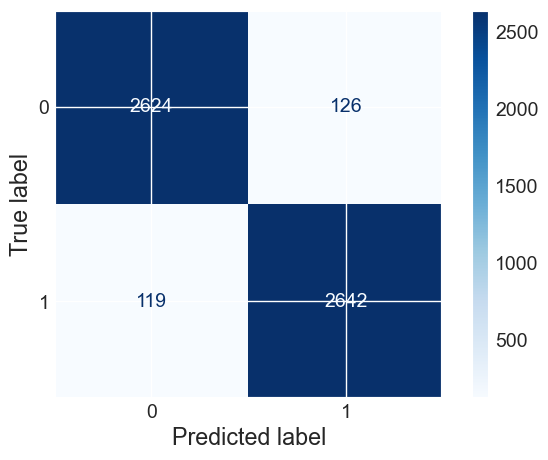

In [65]:
y_proba = model_3.predict(data_generator_test) 
y_pred = (y_proba > 0.5).astype('int')
y_test = data_generator_test.classes

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [39]:
model_file = open('cnn_model_3(3).pkl', 'wb')
joblib.dump(model_3, model_file)
model_file.close()

INFO:tensorflow:Assets written to: ram://fe74c81a-18ff-40f8-b292-9e58ae3d061e/assets


INFO:tensorflow:Assets written to: ram://fe74c81a-18ff-40f8-b292-9e58ae3d061e/assets


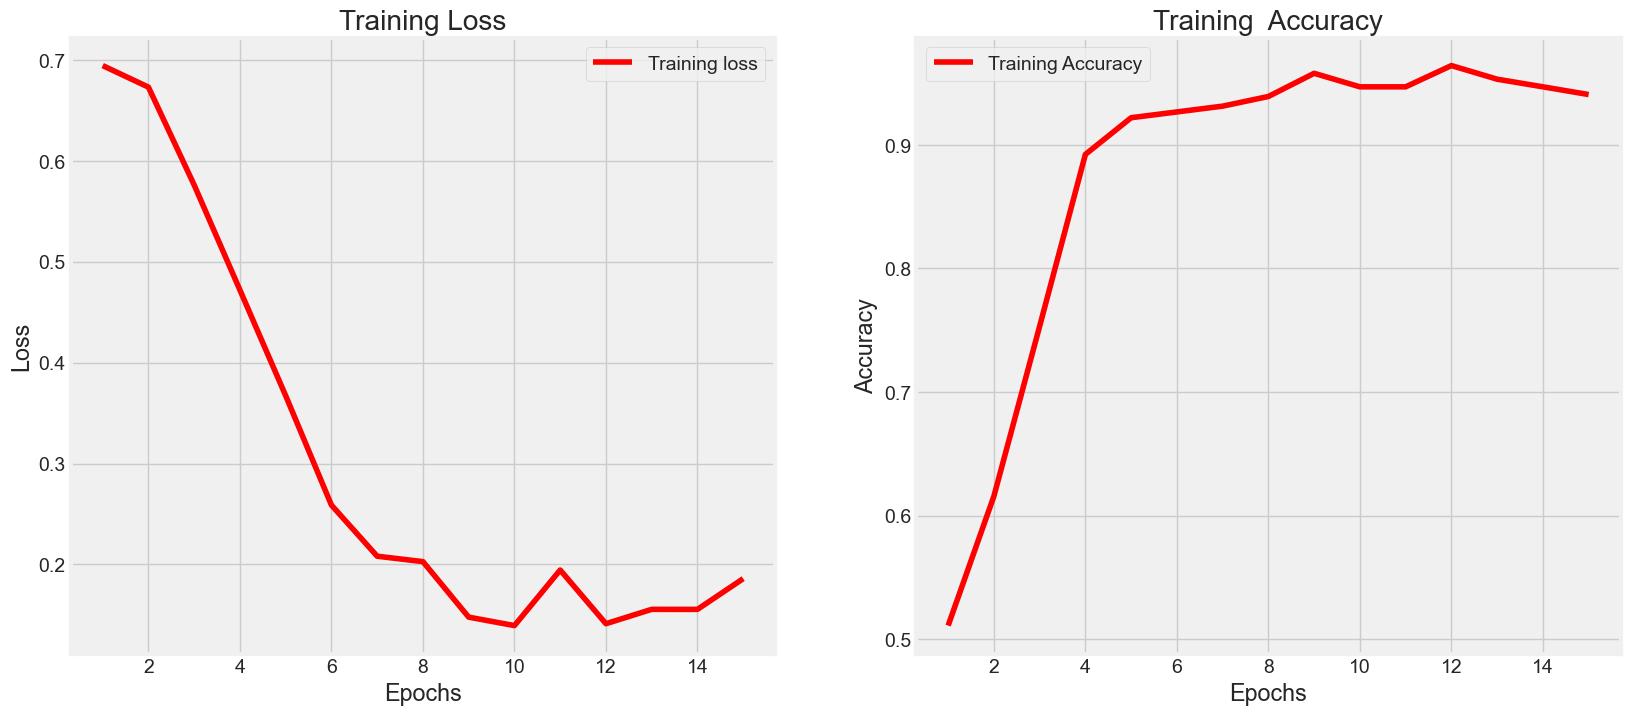

In [31]:
# Define needed variables
tr_acc = history_model_3.history['accuracy']
tr_loss = history_model_3.history['loss']
Epochs = [i+1 for i in range(len(tr_acc))]


# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.title('Training  Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

### Model 4: With Batch Normalization

In [40]:
#instantiate a model
model_4 = Sequential()


# add the input layer  
model_4.add(Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(128, 128, 3)))

keras.layers.BatchNormalization()
# max pool in 2x2 window
model_4.add(MaxPooling2D(pool_size=(2, 2)))


# add second convulutional layer 
model_4.add(Conv2D(filters=64,
                        kernel_size=(3, 3),
                        activation='relu'))

keras.layers.BatchNormalization()
# add second max pool in 2x2 window
model_4.add(MaxPooling2D(pool_size=(2, 2)))


# add third convulutional layer 
model_4.add(Conv2D(filters=128,
                        kernel_size=(3, 3),
                        activation='relu'))

keras.layers.BatchNormalization()
# add third max pool in 2x2 window
model_4.add(MaxPooling2D(pool_size=(2, 2)))


# add fourth convulutional layer 
model_4.add(Conv2D(filters=256,
                        kernel_size=(3, 3),
                        activation='relu'))

keras.layers.BatchNormalization()
# add fourth max pool in 2x2 window
model_4.add(MaxPooling2D(pool_size=(2, 2)))

# add fifth convulutional layer 
model_4.add(Conv2D(filters=512,
                        kernel_size=(3, 3),
                        activation='relu'))

keras.layers.BatchNormalization()
# add fifth max pool in 2x2 window
model_4.add(MaxPooling2D(pool_size=(2, 2)))

# connect all nodes with dense layers
model_4.add(Flatten())
model_4.add(Dense(128, activation='relu'))
model_4.add(Dense(64, activation='relu'))
model_4.add(Dense(32, activation='relu'))
model_4.add(Dense(1, activation='sigmoid'))

#using adam optimizer, binary_crossentropy to measure loss and accuracy as our metric  
model_4.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])

In [41]:
history_model_4 = model_4.fit(data_generator_train, steps_per_epoch = 20, callbacks = callbacks, epochs = 40)

Epoch 1/40


2023-04-18 14:24:02.731655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 3s 105ms/step - loss: 0.6968 - accuracy: 0.4922
Epoch 2/40
20/20 [==============================] - 2s 99ms/step - loss: 0.6935 - accuracy: 0.4813
Epoch 3/40
20/20 [==============================] - 2s 101ms/step - loss: 0.6869 - accuracy: 0.5500
Epoch 4/40
20/20 [==============================] - 2s 100ms/step - loss: 0.6316 - accuracy: 0.6750
Epoch 5/40
20/20 [==============================] - 2s 100ms/step - loss: 0.5464 - accuracy: 0.8438
Epoch 6/40
20/20 [==============================] - 2s 101ms/step - loss: 0.5179 - accuracy: 0.7969
Epoch 7/40
20/20 [==============================] - 2s 99ms/step - loss: 0.4338 - accuracy: 0.8750
Epoch 8/40
20/20 [==============================] - 2s 100ms/step - loss: 0.2966 - accuracy: 0.9031
Epoch 9/40
20/20 [==============================] - 2s 100ms/step - loss: 0.2393 - accuracy: 0.9266
Epoch 10/40
20/20 [==============================] - 2s 99ms/step - loss: 0.2088 - accuracy: 0.9313
Epoch 11/40
2

In [42]:
# returns test accuracy and test loss
test_loss, test_accuracy = model_4.evaluate(data_generator_test, verbose=2)
print(test_loss, test_accuracy)

2023-04-18 14:24:50.188575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


173/173 - 7s - loss: 0.1559 - accuracy: 0.9526 - 7s/epoch - 38ms/step
0.15591682493686676 0.9526402354240417


  4/173 [..............................] - ETA: 3s 

2023-04-18 14:25:03.488123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


173/173 [==============================] - 6s 35ms/step


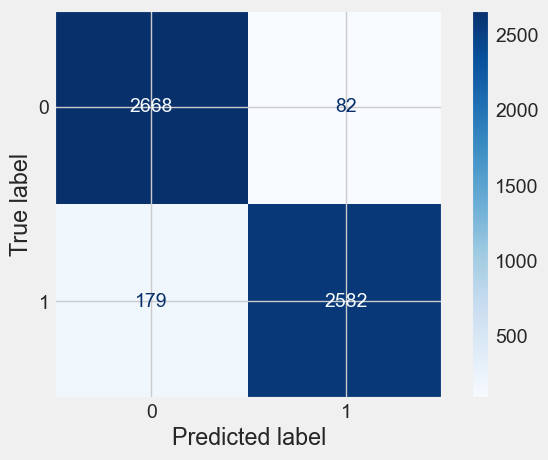

In [43]:
y_proba = model_4.predict(data_generator_test) 
y_pred = (y_proba > 0.5).astype('int')
y_test = data_generator_test.classes

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
with open('cnn_model_4.pkl', 'wb') as f:
    pickle.dump(model_4, f)

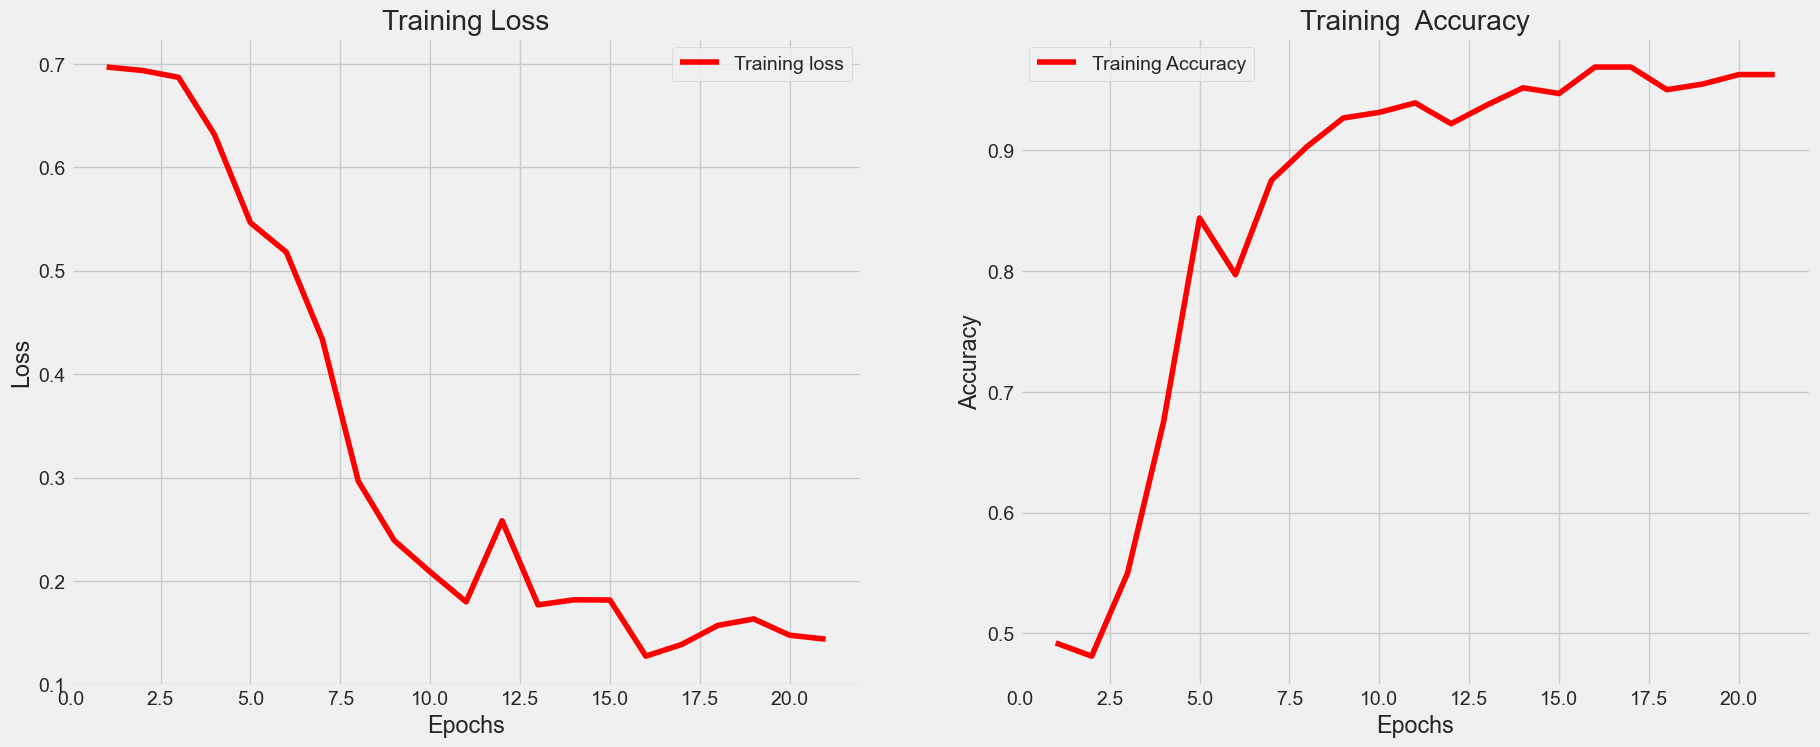

In [44]:
# Define needed variables
tr_acc = history_model_4.history['accuracy']
tr_loss = history_model_4.history['loss']
Epochs = [i+1 for i in range(len(tr_acc))]


# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.title('Training  Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

### Model 5: Adding Additional Layers and Padding



In [45]:
#instantiate a model
model_5 = Sequential()


# add the input layer  
model_5.add(Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        padding='same',
                        input_shape=(128, 128, 3)))

keras.layers.BatchNormalization()

# max pool in 2x2 window
model_5.add(MaxPooling2D(pool_size=(2, 2)))


# add first convulutional layer  
model_5.add(Conv2D(filters=32,
                        kernel_size=(3, 3),
                        padding='same',
                        activation='relu'))

keras.layers.BatchNormalization()
# add first max pool in 2x2 window
model_5.add(MaxPooling2D(pool_size=(2, 2)))


# add second convulutional layer 
model_5.add(Conv2D(filters=64,
                        kernel_size=(3, 3),
                        padding='same',
                        activation='relu'))

keras.layers.BatchNormalization()
# add second max pool in 2x2 window
model_5.add(MaxPooling2D(pool_size=(2, 2)))


# add third convulutional layer 
model_5.add(Conv2D(filters=128,
                        kernel_size=(3, 3),
                        padding='same',
                        activation='relu'))

keras.layers.BatchNormalization()
# add third max pool in 2x2 window
model_5.add(MaxPooling2D(pool_size=(2, 2)))


# add fourth convulutional layer 
model_5.add(Conv2D(filters=64,
                        kernel_size=(3, 3),
                        padding='same',
                        activation='relu'))

keras.layers.BatchNormalization()
# add fourth max pool in 2x2 window
model_5.add(MaxPooling2D(pool_size=(2, 2)))


# add fifth convulutional layer 
model_5.add(Conv2D(filters=256,
                        kernel_size=(3, 3),
                        padding='same',
                        activation='relu'))

keras.layers.BatchNormalization()
# add fifth max pool in 2x2 window
model_5.add(MaxPooling2D(pool_size=(2, 2)))


# add sixth convulutional layer 
model_5.add(Conv2D(filters=128,
                        kernel_size=(3, 3),
                        padding='same',
                        activation='relu'))

keras.layers.BatchNormalization()
# add sixth max pool in 2x2 window
model_5.add(MaxPooling2D(pool_size=(2, 2)))



# add seventh convulutional layer 
model_5.add(Conv2D(filters=512,
                        kernel_size=(3, 3),
                        padding='same',
                        activation='relu'))

keras.layers.BatchNormalization()


# connect all nodes with dense layers
model_5.add(Flatten())
model_5.add(Dense(128, activation='relu'))
model_5.add(Dense(64, activation='relu'))
model_5.add(Dense(32, activation='relu'))
model_5.add(Dense(1, activation='sigmoid'))

#using adam optimizer, binary_crossentropy to measure loss and accuracy as our metric  
model_5.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])

In [46]:
history_model_5 = model_5.fit(data_generator_train, steps_per_epoch = 20, callbacks = callbacks, epochs = 40)

Epoch 1/40


2023-04-18 14:25:30.305613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 4s 78ms/step - loss: 0.6943 - accuracy: 0.5109
Epoch 2/40
20/20 [==============================] - 2s 76ms/step - loss: 0.6932 - accuracy: 0.5078
Epoch 3/40
20/20 [==============================] - 2s 76ms/step - loss: 0.6936 - accuracy: 0.4922
Epoch 4/40
20/20 [==============================] - 2s 75ms/step - loss: 0.6930 - accuracy: 0.5219
Epoch 5/40
20/20 [==============================] - 2s 75ms/step - loss: 0.6932 - accuracy: 0.5047
Epoch 6/40
20/20 [==============================] - 2s 77ms/step - loss: 0.6928 - accuracy: 0.5250
Epoch 7/40
20/20 [==============================] - 2s 77ms/step - loss: 0.6939 - accuracy: 0.4938
Epoch 8/40
20/20 [==============================] - 2s 76ms/step - loss: 0.6934 - accuracy: 0.4922
Epoch 9/40
20/20 [==============================] - 2s 76ms/step - loss: 0.6930 - accuracy: 0.5141
Epoch 10/40
20/20 [==============================] - 2s 87ms/step - loss: 0.6930 - accuracy: 0.5219
Epoch 11/40
20/20 [=

In [47]:
# returns test accuracy and test loss
test_loss, test_accuracy = model_5.evaluate(data_generator_test, verbose=2)
print(test_loss, test_accuracy)

2023-04-18 14:25:53.155281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


173/173 - 6s - loss: 0.6932 - accuracy: 0.4990 - 6s/epoch - 37ms/step
0.6932092308998108 0.49900200963020325


### Model 6: Rearanging Layers

In [48]:
#instantiate a model
model_6 = Sequential()


# add the input layer  
model_6.add(Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(128, 128, 3)))

keras.layers.BatchNormalization()
# max pool in 2x2 window
model_6.add(MaxPooling2D(pool_size=(2, 2)))


# add second convulutional layer 
model_6.add(Conv2D(filters=64,
                        kernel_size=(3, 3),
                        activation='relu'))
model_6.add(Conv2D(filters=64,
                        kernel_size=(3, 3),
                        activation='relu'))

keras.layers.BatchNormalization()
# add second max pool in 2x2 window
model_6.add(MaxPooling2D(pool_size=(2, 2)))


# add third convulutional layer 
model_6.add(Conv2D(filters=128,
                        kernel_size=(3, 3),
                        activation='relu'))
model_6.add(Conv2D(filters=128,
                        kernel_size=(3, 3),
                        activation='relu'))

keras.layers.BatchNormalization()
# add third max pool in 2x2 window
model_6.add(MaxPooling2D(pool_size=(2, 2)))


# add fourth convulutional layer 
model_6.add(Conv2D(filters=256,
                        kernel_size=(3, 3),
                        activation='relu'))
model_6.add(Conv2D(filters=256,
                        kernel_size=(3, 3),
                        activation='relu'))

keras.layers.BatchNormalization()
# add fourth max pool in 2x2 window
model_6.add(MaxPooling2D(pool_size=(2, 2)))

# add fifth convulutional layer 
model_6.add(Conv2D(filters=512,
                        kernel_size=(3, 3),
                        activation='relu'))
model_6.add(Conv2D(filters=512,
                        kernel_size=(3, 3),
                        padding = "same",
                        activation='relu'))

keras.layers.BatchNormalization()
# add fifth max pool in 2x2 window
model_6.add(MaxPooling2D(pool_size=(2, 2)))

# connect all nodes with dense layers
model_6.add(Flatten())
model_6.add(Dense(128, activation='relu'))
model_6.add(Dense(64, activation='relu'))
model_6.add(Dense(32, activation='relu'))
model_6.add(Dense(1, activation='sigmoid'))

#using adam optimizer, binary_crossentropy to measure loss and accuracy as our metric  
model_6.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])

In [49]:
history_model_6 = model_6.fit(data_generator_train, steps_per_epoch = 20, callbacks = callbacks, epochs = 40)

Epoch 1/40


2023-04-18 14:26:09.813988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 4s 158ms/step - loss: 0.6941 - accuracy: 0.4688
Epoch 2/40
20/20 [==============================] - 3s 152ms/step - loss: 0.6934 - accuracy: 0.5234
Epoch 3/40
20/20 [==============================] - 3s 150ms/step - loss: 0.6931 - accuracy: 0.5078
Epoch 4/40
20/20 [==============================] - 3s 150ms/step - loss: 0.6934 - accuracy: 0.4891
Epoch 5/40
20/20 [==============================] - 3s 153ms/step - loss: 0.6931 - accuracy: 0.5469
Epoch 6/40
20/20 [==============================] - 4s 200ms/step - loss: 0.6928 - accuracy: 0.5234
Epoch 7/40
20/20 [==============================] - 3s 164ms/step - loss: 0.6855 - accuracy: 0.5328
Epoch 8/40
20/20 [==============================] - 3s 172ms/step - loss: 0.8017 - accuracy: 0.6016
Epoch 9/40
20/20 [==============================] - 3s 165ms/step - loss: 0.6743 - accuracy: 0.6375
Epoch 10/40
20/20 [==============================] - 3s 155ms/step - loss: 0.6953 - accuracy: 0.4609
Epoch 11/4

### Model 7: adding a 1024 node layer

In [50]:
#instantiate a model
model_7 = Sequential()


# add the input layer  
model_7.add(Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(128, 128, 3)))

keras.layers.BatchNormalization()
# max pool in 2x2 window
model_7.add(MaxPooling2D(pool_size=(2, 2)))


# add second convulutional layer 
model_7.add(Conv2D(filters=64,
                        kernel_size=(3, 3),
                        activation='relu'))

keras.layers.BatchNormalization()
# add second max pool in 2x2 window
model_7.add(MaxPooling2D(pool_size=(2, 2)))


# add third convulutional layer 
model_7.add(Conv2D(filters=128,
                        kernel_size=(3, 3),
                        activation='relu'))

keras.layers.BatchNormalization()
# add third max pool in 2x2 window
model_7.add(MaxPooling2D(pool_size=(2, 2)))


# add fourth convulutional layer 
model_7.add(Conv2D(filters=256,
                        kernel_size=(3, 3),
                        activation='relu'))

keras.layers.BatchNormalization()
# add fourth max pool in 2x2 window
model_7.add(MaxPooling2D(pool_size=(2, 2)))

# add fifth convulutional layer 
model_7.add(Conv2D(filters=512,
                        kernel_size=(3, 3),
                        activation='relu'))

keras.layers.BatchNormalization()
# add fifth max pool in 2x2 window
model_7.add(MaxPooling2D(pool_size=(2, 2)))

# add sixth convulutional layer 
model_7.add(Conv2D(filters=1024,
                        kernel_size=(3, 3),
                        padding = "same",
                        activation='relu'))

keras.layers.BatchNormalization()
# add sixth max pool in 2x2 window
model_7.add(MaxPooling2D(pool_size=(2, 2)))

# connect all nodes with dense layers
model_7.add(Flatten())
model_7.add(Dense(128, activation='relu'))
model_7.add(Dense(64, activation='relu'))
model_7.add(Dense(32, activation='relu'))
model_7.add(Dense(1, activation='sigmoid'))

#using adam optimizer, binary_crossentropy to measure loss and accuracy as our metric  
model_7.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])

In [51]:
history_model_7 = model_7.fit(data_generator_train, steps_per_epoch = 20, callbacks = callbacks, epochs = 40)

Epoch 1/40


2023-04-18 14:27:19.315018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 4s 121ms/step - loss: 0.6977 - accuracy: 0.5188
Epoch 2/40
20/20 [==============================] - 2s 116ms/step - loss: 0.6663 - accuracy: 0.5219
Epoch 3/40
20/20 [==============================] - 2s 115ms/step - loss: 0.5445 - accuracy: 0.8188
Epoch 4/40
20/20 [==============================] - 2s 112ms/step - loss: 0.3711 - accuracy: 0.9219
Epoch 5/40
20/20 [==============================] - 2s 112ms/step - loss: 0.1723 - accuracy: 0.9563
Epoch 6/40
20/20 [==============================] - 2s 113ms/step - loss: 0.1840 - accuracy: 0.9484
Epoch 7/40
20/20 [==============================] - 2s 122ms/step - loss: 0.1483 - accuracy: 0.9594
Epoch 8/40
20/20 [==============================] - 2s 112ms/step - loss: 0.1427 - accuracy: 0.9563
Epoch 9/40
20/20 [==============================] - 3s 127ms/step - loss: 0.1932 - accuracy: 0.9391
Epoch 10/40
20/20 [==============================] - 2s 120ms/step - loss: 0.1313 - accuracy: 0.9594
Epoch 11/4

In [52]:
# returns test accuracy and test loss
test_loss, test_accuracy = model_7.evaluate(data_generator_test, verbose=2)
print(test_loss, test_accuracy)

2023-04-18 14:27:58.615664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


173/173 - 7s - loss: 0.1653 - accuracy: 0.9552 - 7s/epoch - 42ms/step
0.16534601151943207 0.9551805853843689


In [ ]:
with open('cnn_model_7.pkl', 'wb') as f:
    pickle.dump(model_7, f)

  1/173 [..............................] - ETA: 31s

2023-04-18 14:28:05.969459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


173/173 [==============================] - 6s 36ms/step


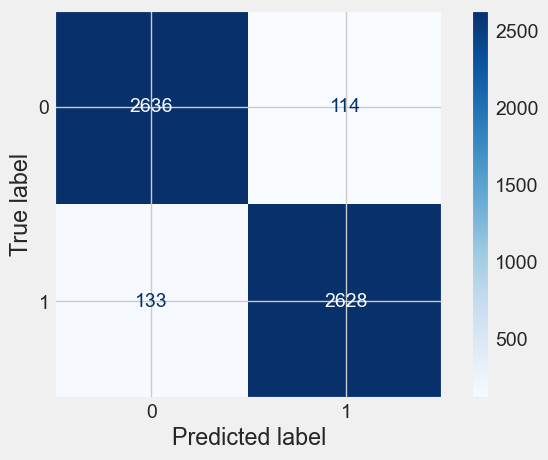

In [53]:
y_proba = model_7.predict(data_generator_test) 
y_pred = (y_proba > 0.5).astype('int')
y_test = data_generator_test.classes

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)

disp.plot(cmap=plt.cm.Blues)
plt.show()

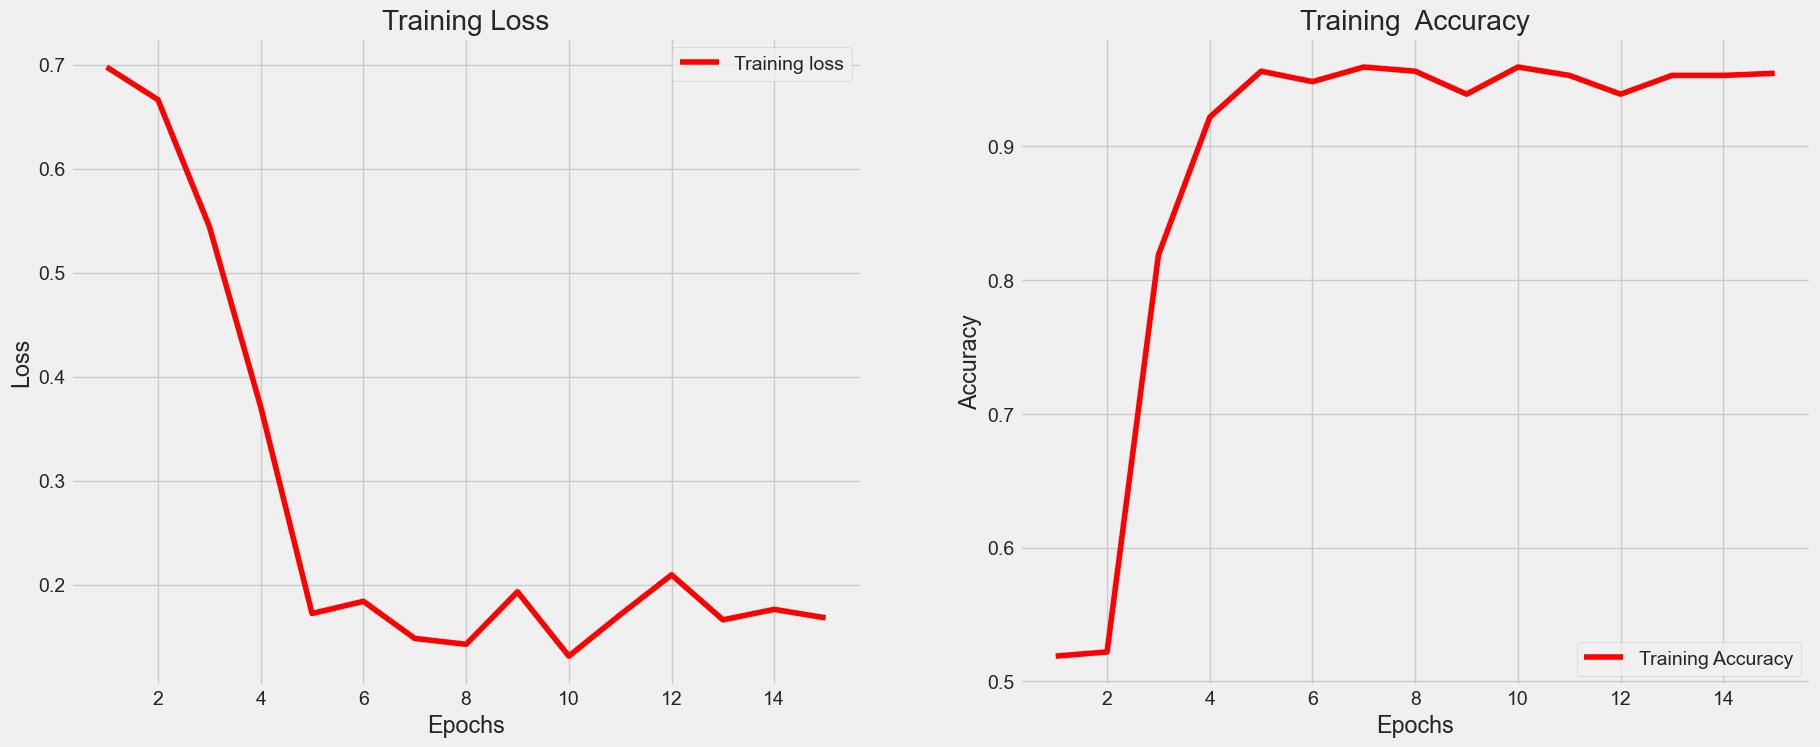

In [54]:
# Define needed variables
tr_acc = history_model_7.history['accuracy']
tr_loss = history_model_7.history['loss']
Epochs = [i+1 for i in range(len(tr_acc))]


# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.title('Training  Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()


### Model 8: One Large Dense Layer

In [ ]:
#instantiate a model
model_8 = Sequential()


# add the input layer  
model_8.add(Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(128, 128, 3)))

keras.layers.BatchNormalization()
# max pool in 2x2 window
model_8.add(MaxPooling2D(pool_size=(2, 2)))


# add second convulutional layer 
model_8.add(Conv2D(filters=64,
                        kernel_size=(3, 3),
                        activation='relu'))

keras.layers.BatchNormalization()
# add second max pool in 2x2 window
model_8.add(MaxPooling2D(pool_size=(2, 2)))


# add third convulutional layer 
model_8.add(Conv2D(filters=128,
                        kernel_size=(3, 3),
                        activation='relu'))

keras.layers.BatchNormalization()
# add third max pool in 2x2 window
model_8.add(MaxPooling2D(pool_size=(2, 2)))


# add fourth convulutional layer 
model_8.add(Conv2D(filters=256,
                        kernel_size=(3, 3),
                        activation='relu'))

keras.layers.BatchNormalization()
# add fourth max pool in 2x2 window
model_8.add(MaxPooling2D(pool_size=(2, 2)))

# add fifth convulutional layer 
model_8.add(Conv2D(filters=512,
                        kernel_size=(3, 3),
                        activation='relu'))

keras.layers.BatchNormalization()
# add fifth max pool in 2x2 window
model_8.add(MaxPooling2D(pool_size=(2, 2)))

# add sixth convulutional layer 
model_8.add(Conv2D(filters=1024,
                        kernel_size=(3, 3),
                        padding = "same",
                        activation='relu'))

keras.layers.BatchNormalization()
# add sixth max pool in 2x2 window
model_8.add(MaxPooling2D(pool_size=(2, 2)))

# connect all nodes with dense layers
model_8.add(Flatten())
model_8.add(Dense(512, activation='relu'))
model_8.add(Dense(1, activation='sigmoid'))

#using adam optimizer, binary_crossentropy to measure loss and accuracy as our metric  
model_8.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])

In [ ]:
history_model_8 = model_8.fit(data_generator_train, steps_per_epoch = 20, callbacks = callbacks, epochs = 40)

Epoch 1/40
20/20 [==============================] - 134s 7s/step - loss: 0.7119 - accuracy: 0.5047
Epoch 2/40
20/20 [==============================] - 127s 6s/step - loss: 0.6915 - accuracy: 0.5250
Epoch 3/40
20/20 [==============================] - 126s 6s/step - loss: 0.6958 - accuracy: 0.4594
Epoch 4/40
20/20 [==============================] - 120s 6s/step - loss: 0.6935 - accuracy: 0.4734
Epoch 5/40
20/20 [==============================] - 119s 6s/step - loss: 0.6928 - accuracy: 0.5281
Epoch 6/40
20/20 [==============================] - 110s 5s/step - loss: 0.6937 - accuracy: 0.4922
Epoch 7/40
20/20 [==============================] - 107s 5s/step - loss: 0.6937 - accuracy: 0.4906


### Model 9: Decreasing Layers

In [ ]:
#instantiate a model
model_9 = Sequential()


# add the input layer  
model_9.add(Conv2D(filters=1024,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(128, 128, 3)))

keras.layers.BatchNormalization()
# max pool in 2x2 window
model_9.add(MaxPooling2D(pool_size=(2, 2)))


# add second convulutional layer 
model_9.add(Conv2D(filters=512,
                        kernel_size=(3, 3),
                        activation='relu'))

keras.layers.BatchNormalization()
# add second max pool in 2x2 window
model_9.add(MaxPooling2D(pool_size=(2, 2)))


# add third convulutional layer 
model_9.add(Conv2D(filters=256,
                        kernel_size=(3, 3),
                        activation='relu'))

keras.layers.BatchNormalization()
# add third max pool in 2x2 window
model_9.add(MaxPooling2D(pool_size=(2, 2)))


# add fourth convulutional layer 
model_9.add(Conv2D(filters=128,
                        kernel_size=(3, 3),
                        activation='relu'))

keras.layers.BatchNormalization()
# add fourth max pool in 2x2 window
model_9.add(MaxPooling2D(pool_size=(2, 2)))

# add fifth convulutional layer 
model_9.add(Conv2D(filters=64,
                        kernel_size=(3, 3),
                        activation='relu'))

keras.layers.BatchNormalization()
# add fifth max pool in 2x2 window
model_9.add(MaxPooling2D(pool_size=(2, 2)))

# add sixth convulutional layer 
model_9.add(Conv2D(filters=32,
                        kernel_size=(3, 3),
                        padding = "same",
                        activation='relu'))

keras.layers.BatchNormalization()
# add sixth max pool in 2x2 window
model_9.add(MaxPooling2D(pool_size=(2, 2)))

# connect all nodes with dense layers
model_9.add(Flatten())
model_9.add(Dense(128, activation='relu'))
model_9.add(Dense(64, activation='relu'))
model_9.add(Dense(32, activation='relu'))
model_9.add(Dense(1, activation='sigmoid'))

#using adam optimizer, binary_crossentropy to measure loss and accuracy as our metric  
model_9.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])

In [ ]:
history_model_9 = model_9.fit(data_generator_train, steps_per_epoch = 20, callbacks = callbacks, epochs = 40)

Epoch 1/40
20/20 [==============================] - 478s 23s/step - loss: 0.6972 - accuracy: 0.5047
Epoch 2/40
20/20 [==============================] - 461s 23s/step - loss: 0.6948 - accuracy: 0.4781
Epoch 3/40
20/20 [==============================] - 440s 22s/step - loss: 0.6936 - accuracy: 0.5000
Epoch 4/40
20/20 [==============================] - 441s 22s/step - loss: 0.6929 - accuracy: 0.5211
Epoch 5/40
20/20 [==============================] - 416s 21s/step - loss: 0.6938 - accuracy: 0.5000
Epoch 6/40
20/20 [==============================] - 408s 20s/step - loss: 0.6934 - accuracy: 0.4953
Epoch 7/40
20/20 [==============================] - 376s 19s/step - loss: 0.6933 - accuracy: 0.5031
Epoch 8/40
20/20 [==============================] - 370s 18s/step - loss: 0.6937 - accuracy: 0.4922
Epoch 9/40
20/20 [==============================] - 362s 18s/step - loss: 0.6933 - accuracy: 0.5125


### Model 10: Transfer Learning

In [ ]:
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= (128,128,3), pooling= 'max')


43941136/43941136 [==============================] - 3s 0us/step


In [ ]:
model_10 = Sequential()
model_10.add(base_model)
model_10.add(layers.Flatten())
model_10.add(layers.Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006), bias_regularizer= regularizers.l1(0.006), activation= 'relu'))
model_10.add(layers.Dropout(rate= 0.45, seed= 123))
model_10.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
# You can check whether a layer is trainable (or alter its setting) through the layer.trainable attribute
for layer in model_10.layers:
    print(layer.name, layer.trainable)
    
# Similarly, you can check how many trainable weights are in the model
print(len(model_10.trainable_weights))

efficientnetb3 True
flatten_1 True
dense_4 True
dropout True
dense_5 True
342


In [ ]:
base_model.trainable = False

In [ ]:
# You can check whether a layer is trainable (or alter its setting) through the layer.trainable attribute
for layer in model_10.layers:
    print(layer.name, layer.trainable)
    
# Similarly, we can check how many trainable weights are in the model
print(len(model_10.trainable_weights))


efficientnetb3 False
flatten_1 True
dense_4 True
dropout True
dense_5 True
4


In [ ]:
model_10.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])

In [ ]:
history_model_10 = model_10.fit(data_generator_train, steps_per_epoch = 20, callbacks = callbacks, epochs = 40)

Epoch 1/40
20/20 [==============================] - 331s 16s/step - loss: 6.7787 - accuracy: 0.4922
Epoch 2/40
20/20 [==============================] - 334s 17s/step - loss: 3.7355 - accuracy: 0.4578
Epoch 3/40
20/20 [==============================] - 313s 16s/step - loss: 2.6249 - accuracy: 0.4688
Epoch 4/40
20/20 [==============================] - 346s 17s/step - loss: 2.0907 - accuracy: 0.4938
Epoch 5/40
20/20 [==============================] - 307s 15s/step - loss: 1.8001 - accuracy: 0.4781
Epoch 6/40
20/20 [==============================] - 306s 15s/step - loss: 1.6033 - accuracy: 0.5063
Epoch 7/40
20/20 [==============================] - 300s 15s/step - loss: 1.4497 - accuracy: 0.5094
Epoch 8/40
20/20 [==============================] - 276s 14s/step - loss: 1.3377 - accuracy: 0.5094
Epoch 9/40
20/20 [==============================] - 262s 13s/step - loss: 1.2401 - accuracy: 0.4984
Epoch 10/40
20/20 [==============================] - 251s 13s/step - loss: 1.1546 - accuracy: 0.5063

KeyboardInterrupt: ignored

### Model 11: VGG19 model

In [58]:
from keras.applications.vgg19 import VGG19

base_model_2 = VGG19(input_shape=(128,128,3), weights='imagenet', include_top=False)

80134624/80134624 [==============================] - 7s 0us/step


In [59]:
base_model_2.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [60]:
model_11 = Sequential()
model_11.add(base_model_2)
model_11.add(layers.Flatten())
model_11.add(Dense(128, activation='relu'))
model_11.add(Dense(64, activation='relu'))
model_11.add(Dense(32, activation='relu'))
model_11.add(layers.Dense(1, activation='sigmoid'))

In [61]:
base_model_2.trainable = False

In [62]:
model_11.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])

In [63]:
history_model_11 = model_11.fit(data_generator_train_VGG19, steps_per_epoch = 20, callbacks = callbacks, epochs = 40)

Epoch 1/40


2023-04-18 14:39:23.083641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 9s 405ms/step - loss: 0.6804 - accuracy: 0.6062
Epoch 2/40
20/20 [==============================] - 8s 396ms/step - loss: 0.4958 - accuracy: 0.7531
Epoch 3/40
20/20 [==============================] - 8s 399ms/step - loss: 0.4559 - accuracy: 0.7906
Epoch 4/40
20/20 [==============================] - 8s 405ms/step - loss: 0.4114 - accuracy: 0.8109
Epoch 5/40
20/20 [==============================] - 8s 396ms/step - loss: 0.3114 - accuracy: 0.8781
Epoch 6/40
20/20 [==============================] - 8s 403ms/step - loss: 0.2845 - accuracy: 0.8859
Epoch 7/40
20/20 [==============================] - 8s 395ms/step - loss: 0.3799 - accuracy: 0.8344
Epoch 8/40
20/20 [==============================] - 8s 397ms/step - loss: 0.3637 - accuracy: 0.8219
Epoch 9/40
20/20 [==============================] - 8s 404ms/step - loss: 0.2508 - accuracy: 0.9047
Epoch 10/40
20/20 [==============================] - 8s 407ms/step - loss: 0.2532 - accuracy: 0.8984
Epoch 11/4

In [64]:
# returns test accuracy and test loss
test_loss, test_accuracy = model_11.evaluate(data_generator_test_VGG19, verbose=2)
print(test_loss, test_accuracy)

2023-04-18 14:42:49.507368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


173/173 - 68s - loss: 0.2195 - accuracy: 0.9131 - 68s/epoch - 391ms/step
0.21953530609607697 0.9130829572677612
